# Sistemas Nebulosos

## Atividade Prática III - ANFIS (Parte 1)

***
### Felipe Bartelt de Assis Pessoa - 2016026841
### Wanderson da Silva Maciel Filho - 2017002660

In [7]:
import torch
import numpy as np
import plotly.graph_objects as go
import anfistorch.experimental as ae
from anfistorch.membership import make_anfis
from torch.utils.data import TensorDataset, DataLoader
from scipy.io import loadmat
import sys
print('Python version: '+sys.version)
print('Numpy version: '+np.__version__, '\nPlotly version: '+__import__('plotly').__version__, '\nPytorch version: ', torch.__version__)

Python version: 3.10.1 (main, Dec 18 2021, 23:53:45) [GCC 11.1.0]
Numpy version: 1.21.5 
Plotly version: 5.5.0 
Pytorch version:  1.10.1


# Problema 1: Aproximação de uma função (Regressão)

> A bilbioteca para ANFIS fornecida foi colocada como um módulo `anfistorch`

Como feito em exercício anterior, aproximou-se a função $\sin(x)$ utilizando 3, 5 e 10 funções de pertinência gaussianas. Abaixo são mostrados os esboços das funções de pertinência, os dados utilizados para treinamento e teste, assim como sua aproximação resultante $\widehat{y}$, e os erros quadráticos médios (MSEs) tanto para treino quanto para os dados de teste.

Primeiramente, gerou-se 1000 amostras da função seno, das quais $70%$ foi utilizada para treinamento de $30%$ para teste, distribuídas aleatoriamente. Somou-se um ruído gaussiano de média nula e desvio padrão $0.2$ à função seno. Assim, utilizando-se a biblioteca fornecida, treinou-se a ANFIS.

In [8]:
def plot_all_mfs(model, x):
    'Modified for plotly'
    fig = go.Figure()
    for i, (var_name, fv) in enumerate(model.layer.fuzzify.varmfs.items()):
        xsort, _ = x[:, i].sort()
        for mfname, yvals in fv.fuzzify(xsort):
            fig.add_scatter(x=xsort.detach().numpy().ravel(), y=yvals.detach().numpy().ravel(), name=mfname+'_'+var_name)
    fig.update_xaxes(title='Values for MFs')
    fig.update_yaxes(title='Membership')
    return fig

In [94]:
x = np.linspace(0, 2*np.pi, 1000).reshape(-1, 1)
noise = np.random.default_rng().normal(scale=0.2, size=x.shape)
y = np.sin(x) + noise
train_size = int(0.7 * x.shape[0])
idxs = np.arange(x.shape[0])
np.random.default_rng().shuffle(idxs)
xtrain = torch.Tensor(x[idxs[:train_size]])
xtest = torch.Tensor(x[idxs[train_size:]])
ytrain = torch.Tensor(y[idxs[:train_size]])
ytest = torch.Tensor(y[idxs[train_size:]])
td = TensorDataset(xtrain, ytrain)
data = DataLoader(td, shuffle=False)

## 3 funções de pertinência Gaussianas

In [95]:
xt, y_actual = data.dataset.tensors
model = make_anfis(xt, num_mfs=3, num_out=1, hybrid=False)

In [96]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss(reduction='sum')
ae.train_anfis_with(model, data, optimizer, criterion, epochs=50)

### Training for 50 epochs, training size = 700 cases
epoch    0: MSE=0.44400, RMSE=0.66633 =111.88%
epoch   10: MSE=0.20488, RMSE=0.45264 =180.71%
epoch   20: MSE=0.11392, RMSE=0.33752 =191.01%
epoch   30: MSE=0.06603, RMSE=0.25697 =167.11%
epoch   40: MSE=0.05193, RMSE=0.22789 =145.24%


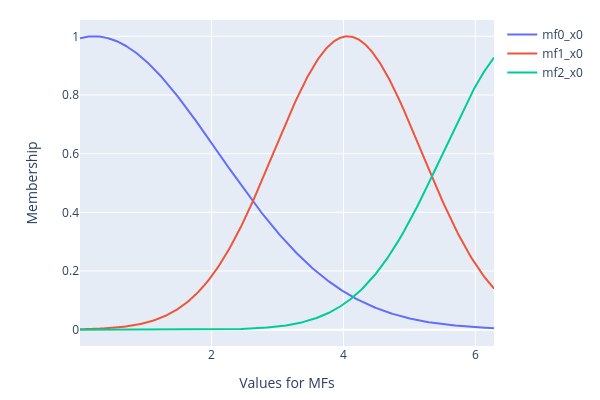

In [97]:
fig = plot_all_mfs(model, xt)
fig.update_layout(margin=dict(t=20, b=20, r=20))
fig.show(renderer='png', width=600, height=400)

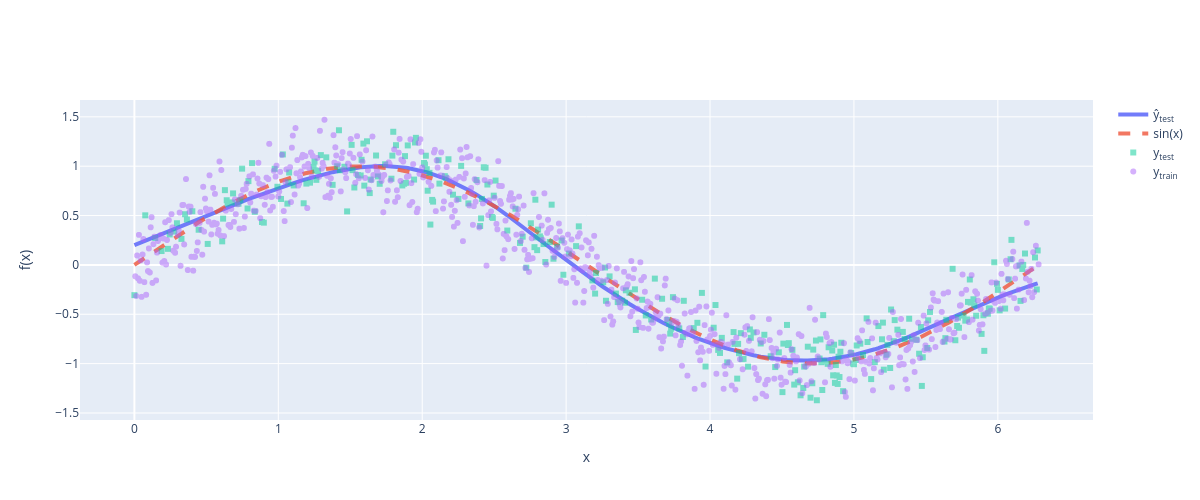

In [110]:
yhat_train = model(xtrain)
yhat_test = model(xtest)

xtrain_ = xtrain.detach().numpy()
ord_train = np.argsort(xtrain_.ravel())
xtrain_ = xtrain_[ord_train]
xtest_ = xtest.detach().numpy()
ord_test = np.argsort(xtest_.ravel())
xtest_ = xtest_[ord_test]
ytrain_ = ytrain.detach().numpy()[ord_train]
ytest_ = ytest.detach().numpy()[ord_test]

fig = go.Figure(go.Scatter(x=xtest_.ravel(), y=yhat_test.detach().numpy().ravel()[ord_test], name='ŷ<sub>test</sub>', line_width=4, opacity=0.9))
fig.add_scatter(x=x.ravel(), y=np.sin(x).ravel(), name='sin(x)', line_dash='dash', line_width=4, opacity=0.8)
fig.add_scatter(x=xtest_.ravel(), y=ytest_.ravel(), name='y<sub>test</sub>', marker_symbol='square', opacity=0.5, mode='markers')
fig.add_scatter(x=xtrain_.ravel(), y=ytrain_.ravel(), name='y<sub>train</sub>', opacity=0.5, mode='markers')
fig.update_xaxes(title='x')
fig.update_yaxes(title='f(x)')
fig.show(renderer='png', width=1200, height=500)

In [111]:
yhat_= yhat_train.detach().numpy()[ord_train]
yhatt_= yhat_test.detach().numpy()[ord_test]
mse = ((ytrain_ - yhat_).T @ (ytrain_ - yhat_)) / yhat_.shape[0]
mse2 = ((ytest_ - yhatt_).T @ (ytest_ - yhatt_)) / yhatt_.shape[0]
print('MSE train: ', mse.ravel(), '\nMSE test: ', mse2.ravel())

MSE train:  [0.04846567] 
MSE test:  [0.03908708]


## 5 funções de pertinência Gaussianas

In [112]:
xt, y_actual = data.dataset.tensors
model = make_anfis(xt, num_mfs=5, num_out=1, hybrid=False)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss(reduction='sum')
ae.train_anfis_with(model, data, optimizer, criterion, epochs=50)

### Training for 50 epochs, training size = 700 cases
epoch    0: MSE=0.40889, RMSE=0.63944 =109.92%
epoch   10: MSE=0.06944, RMSE=0.26352 =150.27%
epoch   20: MSE=0.05105, RMSE=0.22594 =132.99%
epoch   30: MSE=0.04957, RMSE=0.22264 =127.80%
epoch   40: MSE=0.04849, RMSE=0.22020 =124.81%


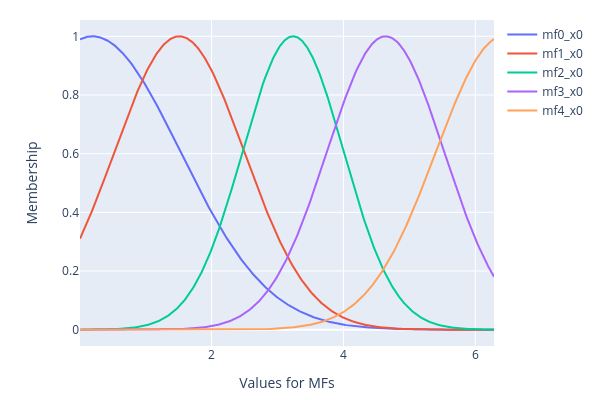

In [113]:
fig = plot_all_mfs(model, xt)
fig.update_layout(margin=dict(t=20, b=20, r=20))
fig.show(renderer='png', width=600, height=400)

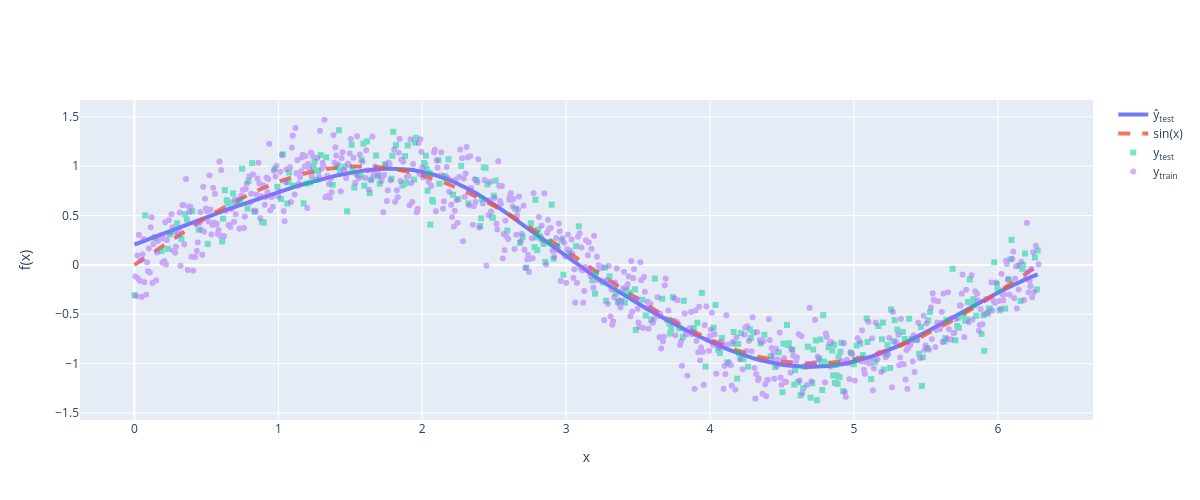

In [114]:
yhat_train = model(xtrain)
yhat_test = model(xtest)

xtrain_ = xtrain.detach().numpy()
ord_train = np.argsort(xtrain_.ravel())
xtrain_ = xtrain_[ord_train]
xtest_ = xtest.detach().numpy()
ord_test = np.argsort(xtest_.ravel())
xtest_ = xtest_[ord_test]
ytrain_ = ytrain.detach().numpy()[ord_train]
ytest_ = ytest.detach().numpy()[ord_test]

fig = go.Figure(go.Scatter(x=xtest_.ravel(), y=yhat_test.detach().numpy().ravel()[ord_test], name='ŷ<sub>test</sub>', line_width=4, opacity=0.9))
fig.add_scatter(x=x.ravel(), y=np.sin(x).ravel(), name='sin(x)', line_dash='dash', line_width=4, opacity=0.8)
fig.add_scatter(x=xtest_.ravel(), y=ytest_.ravel(), name='y<sub>test</sub>', marker_symbol='square', opacity=0.5, mode='markers')
fig.add_scatter(x=xtrain_.ravel(), y=ytrain_.ravel(), name='y<sub>train</sub>', opacity=0.5, mode='markers')
fig.update_xaxes(title='x')
fig.update_yaxes(title='f(x)')
fig.show(renderer='png', width=1200, height=500)

In [115]:
yhat_= yhat_train.detach().numpy()[ord_train]
yhatt_= yhat_test.detach().numpy()[ord_test]
mse = ((ytrain_ - yhat_).T @ (ytrain_ - yhat_)) / yhat_.shape[0]
mse2 = ((ytest_ - yhatt_).T @ (ytest_ - yhatt_)) / yhatt_.shape[0]
print('MSE train: ', mse.ravel(), '\nMSE test: ', mse2.ravel())

MSE train:  [0.04772446] 
MSE test:  [0.03851882]


## 10 funções de pertinência Gaussianas

In [116]:
xt, y_actual = data.dataset.tensors
model = make_anfis(xt, num_mfs=10, num_out=1, hybrid=False)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss(reduction='sum')
ae.train_anfis_with(model, data, optimizer, criterion, epochs=50)

### Training for 50 epochs, training size = 700 cases
epoch    0: MSE=0.38805, RMSE=0.62293 =103.39%
epoch   10: MSE=0.05611, RMSE=0.23688 =124.77%
epoch   20: MSE=0.04580, RMSE=0.21402 =116.19%
epoch   30: MSE=0.04466, RMSE=0.21133 =109.66%
epoch   40: MSE=0.04437, RMSE=0.21064 =106.86%


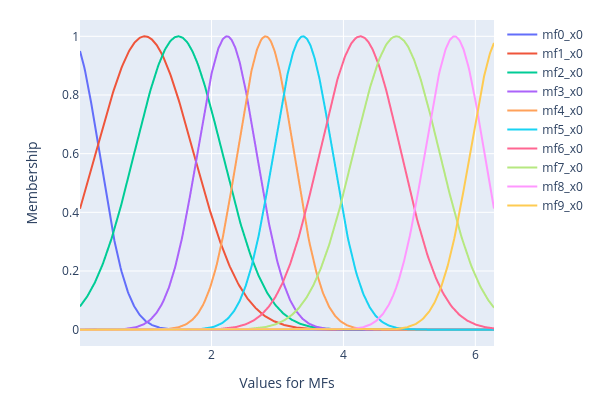

In [117]:
fig = plot_all_mfs(model, xt)
fig.update_layout(margin=dict(t=20, b=20, r=20))
fig.show(renderer='png', width=600, height=400)

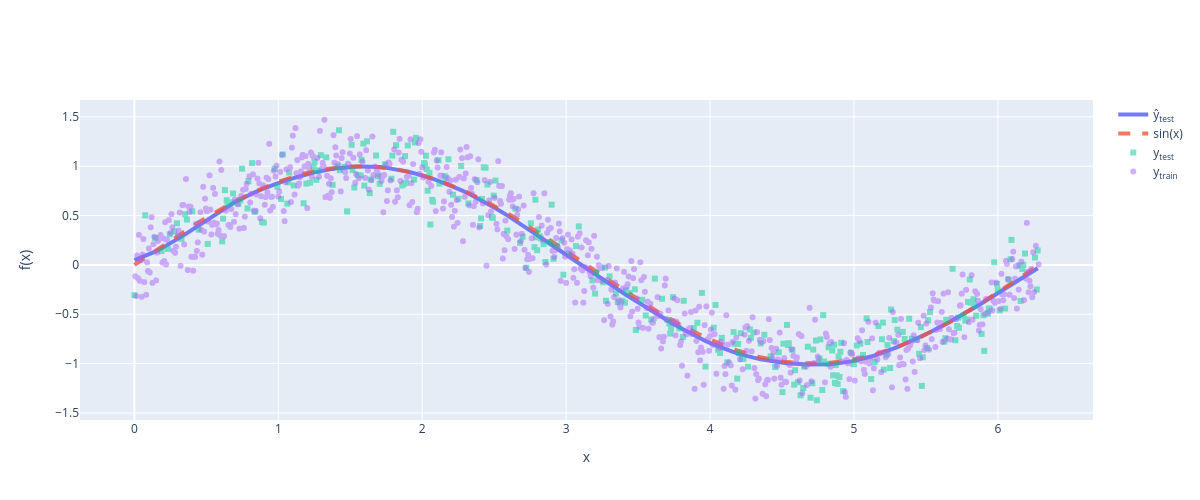

In [118]:
yhat_train = model(xtrain)
yhat_test = model(xtest)

xtrain_ = xtrain.detach().numpy()
ord_train = np.argsort(xtrain_.ravel())
xtrain_ = xtrain_[ord_train]
xtest_ = xtest.detach().numpy()
ord_test = np.argsort(xtest_.ravel())
xtest_ = xtest_[ord_test]
ytrain_ = ytrain.detach().numpy()[ord_train]
ytest_ = ytest.detach().numpy()[ord_test]

fig = go.Figure(go.Scatter(x=xtest_.ravel(), y=yhat_test.detach().numpy().ravel()[ord_test], name='ŷ<sub>test</sub>', line_width=4, opacity=0.9))
fig.add_scatter(x=x.ravel(), y=np.sin(x).ravel(), name='sin(x)', line_dash='dash', line_width=4, opacity=0.8)
fig.add_scatter(x=xtest_.ravel(), y=ytest_.ravel(), name='y<sub>test</sub>', marker_symbol='square', opacity=0.5, mode='markers')
fig.add_scatter(x=xtrain_.ravel(), y=ytrain_.ravel(), name='y<sub>train</sub>', opacity=0.5, mode='markers')
fig.update_xaxes(title='x')
fig.update_yaxes(title='f(x)')
fig.show(renderer='png', width=1200, height=500)

In [119]:
yhat_= yhat_train.detach().numpy()[ord_train]
yhatt_= yhat_test.detach().numpy()[ord_test]
mse = ((ytrain_ - yhat_).T @ (ytrain_ - yhat_)) / yhat_.shape[0]
mse2 = ((ytest_ - yhatt_).T @ (ytest_ - yhatt_)) / yhatt_.shape[0]
print('MSE train: ', mse.ravel(), '\nMSE test: ', mse2.ravel())

MSE train:  [0.0442643] 
MSE test:  [0.03778318]


Com os resultados, nota-se um melhor desempenho para a rede com 10 funções de pertinência, entretano a diferença entre os erros quadráticos médios obtidos para os três casos foram muito próximos, sendo necessário assim um estudo de validação cruzada ou somente um aumento no número de épocas para a convergência do algoritmo, para que se confirme qual a melhor configuração de rede.

# Problema 2: Previsão de uma série temporal

Dado a necessidade de memória do sistema, a amostra correspondente a $x(t_0)$ é tomada como a 18° amostra, de tal forma que $x(t-18)$ corresponda à primeira amostra. Assim, construíu-se os vetores auxiliares $x_0, x_1, x_2, x_3$, correspondentes às *features* do problema. Para a saída do sistema, tomou-se as amostras a partir do 24° índice. Tomou-se como amostras de treino, as 80% primeiras linhas da matriz $\begin{bmatrix}x_0& x_1& x_2& x_3\end{bmatrix}$ e o restante para como amostras de teste. Seguindo a mesma proporção o mesmo foi feito para as amostras de saída do sistema, que resulta em 6 amostras de teste a menos para a saída do sistema, o que somente importa ao se calcular o MSE, uma vez que o resultado previsto para $x_\text{test}$ nada mais é que o próprio objetivo.

Dessa forma, mostra-se abaixo os esboços das funções de pertinência, amostras de treino e teste, assim como suas respostas aproximadas e os MSEs.

In [72]:
data = loadmat('mg.mat')
y = data['x']
x = np.arange(y.shape[0])

In [73]:
x0 = y[:-18] # x(t - 18)
x1 = y[6:-12] # x(t - 12)
x2 = y[12:-6] # x(t - 6)
x3 = y[18:] # x(t)
X = np.c_[x0, x1, x2, x3]
aux = x[18:] + 6
Y = y[aux[aux < y.shape[0]]]

train_size = int(0.8 * X.shape[0])
ytrain = Y[:train_size]
xtrain = X[:train_size]
ytest = Y[train_size:]
xtest = X[train_size:]
print(y.shape, (xtrain.shape, ytrain.shape), (xtest.shape, ytest.shape))

(1001, 1) ((786, 4), (786, 1)) ((197, 4), (191, 1))


In [74]:
xt = torch.Tensor(xtrain)
yt = torch.Tensor(ytrain)
td = TensorDataset(xt, yt)
data = DataLoader(td, shuffle=False)
xt, y_actual = data.dataset.tensors
model = make_anfis(xt, num_mfs=2, num_out=1, hybrid=False)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = torch.nn.MSELoss(reduction='sum')
ae.train_anfis_with(model, data, optimizer, criterion, epochs=100)

### Training for 100 epochs, training size = 786 cases
epoch    0: MSE=0.47271, RMSE=0.68754 =66.95%
epoch   10: MSE=0.00638, RMSE=0.07988 =7.59%
epoch   20: MSE=0.00472, RMSE=0.06871 =6.57%
epoch   30: MSE=0.00406, RMSE=0.06370 =6.09%
epoch   40: MSE=0.00365, RMSE=0.06041 =5.73%
epoch   50: MSE=0.00227, RMSE=0.04762 =4.32%
epoch   60: MSE=0.00079, RMSE=0.02806 =2.56%
epoch   70: MSE=0.00045, RMSE=0.02122 =1.90%
epoch   80: MSE=0.00037, RMSE=0.01922 =1.71%
epoch   90: MSE=0.00033, RMSE=0.01812 =1.60%


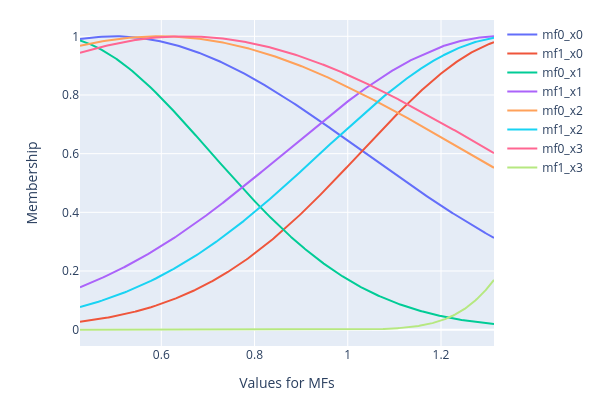

In [75]:
fig = plot_all_mfs(model, xt)
fig.update_layout(margin=dict(t=20, b=20, r=20))
fig.show(renderer='png', width=600, height=400)

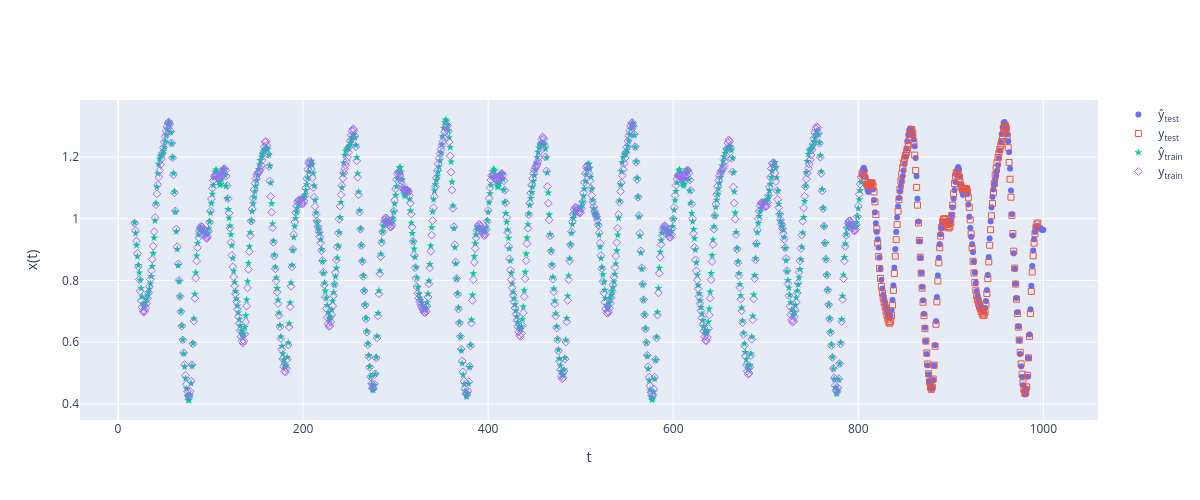

In [79]:
yhat = model(torch.Tensor(xtest))
yhatt = model(xt)
xg = x[18:]

fig = go.Figure(go.Scatter(x=xg[train_size:].ravel(), y=yhat.detach().numpy().ravel(), name='ŷ<sub>test</sub>', mode='markers'))
fig.add_scatter(x=xg[train_size:].ravel(), y=ytest.ravel(), name='y<sub>test</sub>', mode='markers', marker_symbol='square-open')
fig.add_scatter(x=xg[:train_size].ravel(), y=yhatt.detach().numpy().ravel(), name='ŷ<sub>train</sub>', mode='markers', marker_symbol='star')
fig.add_scatter(x=xg[:train_size].ravel(), y=ytrain.ravel(), name='y<sub>train</sub>', mode='markers', marker_symbol='diamond-open')
fig.update_xaxes(title='t')
fig.update_yaxes(title='x(t)')
fig.show(renderer='png', width=1200, height=500)

In [80]:
yhat_= yhat.detach().numpy()[:-6]
yhatt_= yhatt.detach().numpy()
mse = ((ytest - yhat_).T @ (ytest - yhat_)) / yhat.shape[0]
mse2 = ((ytrain - yhatt_).T @ (ytrain - yhatt_)) / yhatt.shape[0]
print('MSE train: ', mse2.ravel(), '\nMSE test: ', mse.ravel())

MSE train:  [0.00030052] 
MSE test:  [0.0002633]


Nota-se que a aproximação obtida foi excelente, obtendo-se um erro quadrático médio de apenas $0.026\%$ nos dados de teste. 

***

# IGNORAR

> A classe *DataLoader* do pytorch gera um erro no Python 3.10. O trecho abaixo é somente uma modificação para forçar seu funcionamento

In [9]:
import os
import threading
import itertools
import warnings
import queue
from typing import Any, Callable, TypeVar, Generic, Sequence, List, Optional

import multiprocessing as python_multiprocessing
import torch
import torch.multiprocessing as multiprocessing
from torch._utils import ExceptionWrapper
from torch._six import string_classes

from torch.utils.data import IterableDataset, Sampler, SequentialSampler, RandomSampler, BatchSampler, Dataset
from torch.utils.data import _utils

T_co = TypeVar('T_co', covariant=True)
T = TypeVar('T')
_worker_init_fn_t = Callable[[int], None]

# Ideally we would parameterize `DataLoader` by the return type of `collate_fn`, but there is currently no way to have that
# type parameter set to a default value if the user doesn't pass in a custom 'collate_fn'.
# See https://github.com/python/mypy/issues/3737.
_collate_fn_t = Callable[[List[T]], Any]


# This function used to be defined in this file. However, it was moved to
# _utils/collate.py. Although it is rather hard to access this from user land
# (one has to explicitly directly `import torch.utils.data.dataloader`), there
# probably is user code out there using it. This aliasing maintains BC in this
# aspect.
default_collate: _collate_fn_t = _utils.collate.default_collate

get_worker_info = _utils.worker.get_worker_info


class _DatasetKind(object):
    Map = 0
    Iterable = 1

    @staticmethod
    def create_fetcher(kind, dataset, auto_collation, collate_fn, drop_last):
        if kind == _DatasetKind.Map:
            return _utils.fetch._MapDatasetFetcher(dataset, auto_collation, collate_fn, drop_last)
        else:
            return _utils.fetch._IterableDatasetFetcher(dataset, auto_collation, collate_fn, drop_last)


class _InfiniteConstantSampler(Sampler):
    r"""Analogous to ``itertools.repeat(None, None)``.
    Used as sampler for :class:`~torch.utils.data.IterableDataset`.

    Args:
        data_source (Dataset): dataset to sample from
    """

    def __init__(self):
        super(_InfiniteConstantSampler, self).__init__(None)

    def __iter__(self):
        while True:
            yield None


class DataLoader(Generic[T_co]):
    r"""
    Data loader. Combines a dataset and a sampler, and provides an iterable over
    the given dataset.

    The :class:`~torch.utils.data.DataLoader` supports both map-style and
    iterable-style datasets with single- or multi-process loading, customizing
    loading order and optional automatic batching (collation) and memory pinning.

    See :py:mod:`torch.utils.data` documentation page for more details.

    Args:
        dataset (Dataset): dataset from which to load the data.
        batch_size (int, optional): how many samples per batch to load
            (default: ``1``).
        shuffle (bool, optional): set to ``True`` to have the data reshuffled
            at every epoch (default: ``False``).
        sampler (Sampler or Iterable, optional): defines the strategy to draw
            samples from the dataset. Can be any ``Iterable`` with ``__len__``
            implemented. If specified, :attr:`shuffle` must not be specified.
        batch_sampler (Sampler or Iterable, optional): like :attr:`sampler`, but
            returns a batch of indices at a time. Mutually exclusive with
            :attr:`batch_size`, :attr:`shuffle`, :attr:`sampler`,
            and :attr:`drop_last`.
        num_workers (int, optional): how many subprocesses to use for data
            loading. ``0`` means that the data will be loaded in the main process.
            (default: ``0``)
        collate_fn (callable, optional): merges a list of samples to form a
            mini-batch of Tensor(s).  Used when using batched loading from a
            map-style dataset.
        pin_memory (bool, optional): If ``True``, the data loader will copy Tensors
            into CUDA pinned memory before returning them.  If your data elements
            are a custom type, or your :attr:`collate_fn` returns a batch that is a custom type,
            see the example below.
        drop_last (bool, optional): set to ``True`` to drop the last incomplete batch,
            if the dataset size is not divisible by the batch size. If ``False`` and
            the size of dataset is not divisible by the batch size, then the last batch
            will be smaller. (default: ``False``)
        timeout (numeric, optional): if positive, the timeout value for collecting a batch
            from workers. Should always be non-negative. (default: ``0``)
        worker_init_fn (callable, optional): If not ``None``, this will be called on each
            worker subprocess with the worker id (an int in ``[0, num_workers - 1]``) as
            input, after seeding and before data loading. (default: ``None``)
        generator (torch.Generator, optional): If not ``None``, this RNG will be used
            by RandomSampler to generate random indexes and multiprocessing to generate
            `base_seed` for workers. (default: ``None``)
        prefetch_factor (int, optional, keyword-only arg): Number of samples loaded
            in advance by each worker. ``2`` means there will be a total of
            2 * num_workers samples prefetched across all workers. (default: ``2``)
        persistent_workers (bool, optional): If ``True``, the data loader will not shutdown
            the worker processes after a dataset has been consumed once. This allows to
            maintain the workers `Dataset` instances alive. (default: ``False``)


    .. warning:: If the ``spawn`` start method is used, :attr:`worker_init_fn`
                 cannot be an unpicklable object, e.g., a lambda function. See
                 :ref:`multiprocessing-best-practices` on more details related
                 to multiprocessing in PyTorch.

    .. warning:: ``len(dataloader)`` heuristic is based on the length of the sampler used.
                 When :attr:`dataset` is an :class:`~torch.utils.data.IterableDataset`,
                 it instead returns an estimate based on ``len(dataset) / batch_size``, with proper
                 rounding depending on :attr:`drop_last`, regardless of multi-process loading
                 configurations. This represents the best guess PyTorch can make because PyTorch
                 trusts user :attr:`dataset` code in correctly handling multi-process
                 loading to avoid duplicate data.

                 However, if sharding results in multiple workers having incomplete last batches,
                 this estimate can still be inaccurate, because (1) an otherwise complete batch can
                 be broken into multiple ones and (2) more than one batch worth of samples can be
                 dropped when :attr:`drop_last` is set. Unfortunately, PyTorch can not detect such
                 cases in general.

                 See `Dataset Types`_ for more details on these two types of datasets and how
                 :class:`~torch.utils.data.IterableDataset` interacts with
                 `Multi-process data loading`_.

    .. warning:: See :ref:`reproducibility`, and :ref:`dataloader-workers-random-seed`, and
                 :ref:`data-loading-randomness` notes for random seed related questions.
    """
    dataset: Dataset[T_co]
    batch_size: Optional[int]
    num_workers: int
    pin_memory: bool
    drop_last: bool
    timeout: float
    sampler: Sampler
    prefetch_factor: int
    _iterator : Optional['_BaseDataLoaderIter']
    __initialized = False

    def __init__(self, dataset: Dataset[T_co], batch_size: Optional[int] = 1,
                 shuffle: bool = False, sampler: Optional[Sampler] = None,
                 batch_sampler: Optional[Sampler[Sequence]] = None,
                 num_workers: int = 0, collate_fn: Optional[_collate_fn_t] = None,
                 pin_memory: bool = False, drop_last: bool = False,
                 timeout: float = 0, worker_init_fn: Optional[_worker_init_fn_t] = None,
                 multiprocessing_context=None, generator=None,
                 *, prefetch_factor: int = 2,
                 persistent_workers: bool = False):
        torch._C._log_api_usage_once("python.data_loader")

        if num_workers < 0:
            raise ValueError('num_workers option should be non-negative; '
                             'use num_workers=0 to disable multiprocessing.')

        if timeout < 0:
            raise ValueError('timeout option should be non-negative')

        if num_workers == 0 and prefetch_factor != 2:
            raise ValueError('prefetch_factor option could only be specified in multiprocessing.'
                             'let num_workers > 0 to enable multiprocessing.')
        assert prefetch_factor > 0

        if persistent_workers and num_workers == 0:
            raise ValueError('persistent_workers option needs num_workers > 0')

        self.dataset = dataset
        self.num_workers = num_workers
        self.prefetch_factor = prefetch_factor
        self.pin_memory = pin_memory
        self.timeout = timeout
        self.worker_init_fn = worker_init_fn
        self.multiprocessing_context = multiprocessing_context

        # Arg-check dataset related before checking samplers because we want to
        # tell users that iterable-style datasets are incompatible with custom
        # samplers first, so that they don't learn that this combo doesn't work
        # after spending time fixing the custom sampler errors.
        if True:
            self._dataset_kind = _DatasetKind.Iterable
            # NOTE [ Custom Samplers and IterableDataset ]
            #
            # `IterableDataset` does not support custom `batch_sampler` or
            # `sampler` since the key is irrelevant (unless we support
            # generator-style dataset one day...).
            #
            # For `sampler`, we always create a dummy sampler. This is an
            # infinite sampler even when the dataset may have an implemented
            # finite `__len__` because in multi-process data loading, naive
            # settings will return duplicated data (which may be desired), and
            # thus using a sampler with length matching that of dataset will
            # cause data lost (you may have duplicates of the first couple
            # batches, but never see anything afterwards). Therefore,
            # `Iterabledataset` always uses an infinite sampler, an instance of
            # `_InfiniteConstantSampler` defined above.
            #
            # A custom `batch_sampler` essentially only controls the batch size.
            # However, it is unclear how useful it would be since an iterable-style
            # dataset can handle that within itself. Moreover, it is pointless
            # in multi-process data loading as the assignment order of batches
            # to workers is an implementation detail so users can not control
            # how to batchify each worker's iterable. Thus, we disable this
            # option. If this turns out to be useful in future, we can re-enable
            # this, and support custom samplers that specify the assignments to
            # specific workers.
            if shuffle is not False:
                raise ValueError(
                    "DataLoader with IterableDataset: expected unspecified "
                    "shuffle option, but got shuffle={}".format(shuffle))
            elif sampler is not None:
                # See NOTE [ Custom Samplers and IterableDataset ]
                raise ValueError(
                    "DataLoader with IterableDataset: expected unspecified "
                    "sampler option, but got sampler={}".format(sampler))
            elif batch_sampler is not None:
                # See NOTE [ Custom Samplers and IterableDataset ]
                raise ValueError(
                    "DataLoader with IterableDataset: expected unspecified "
                    "batch_sampler option, but got batch_sampler={}".format(batch_sampler))
        else:
            self._dataset_kind = _DatasetKind.Map

        if sampler is not None and shuffle:
            raise ValueError('sampler option is mutually exclusive with '
                             'shuffle')

        if batch_sampler is not None:
            # auto_collation with custom batch_sampler
            if batch_size != 1 or shuffle or sampler is not None or drop_last:
                raise ValueError('batch_sampler option is mutually exclusive '
                                 'with batch_size, shuffle, sampler, and '
                                 'drop_last')
            batch_size = None
            drop_last = False
        elif batch_size is None:
            # no auto_collation
            if drop_last:
                raise ValueError('batch_size=None option disables auto-batching '
                                 'and is mutually exclusive with drop_last')

        if sampler is None:  # give default samplers
            if self._dataset_kind == _DatasetKind.Iterable:
                # See NOTE [ Custom Samplers and IterableDataset ]
                sampler = _InfiniteConstantSampler()
            else:  # map-style
                if shuffle:
                    sampler = RandomSampler(dataset, generator=generator)
                else:
                    sampler = SequentialSampler(dataset)

        if batch_size is not None and batch_sampler is None:
            # auto_collation without custom batch_sampler
            batch_sampler = BatchSampler(sampler, batch_size, drop_last)

        self.batch_size = batch_size
        self.drop_last = drop_last
        self.sampler = sampler
        self.batch_sampler = batch_sampler
        self.generator = generator

        if collate_fn is None:
            if self._auto_collation:
                collate_fn = _utils.collate.default_collate
            else:
                collate_fn = _utils.collate.default_convert

        self.collate_fn = collate_fn
        self.persistent_workers = persistent_workers

        self.__initialized = True
        self._IterableDataset_len_called = None  # See NOTE [ IterableDataset and __len__ ]

        self._iterator = None

        self.check_worker_number_rationality()

        torch.set_vital('Dataloader', 'enabled', 'True')  # type: ignore[attr-defined]

    def _get_iterator(self) -> '_BaseDataLoaderIter':
        if self.num_workers == 0:
            return _SingleProcessDataLoaderIter(self)
        else:
            self.check_worker_number_rationality()
            return _MultiProcessingDataLoaderIter(self)

    @property
    def multiprocessing_context(self):
        return self.__multiprocessing_context

    @multiprocessing_context.setter
    def multiprocessing_context(self, multiprocessing_context):
        if multiprocessing_context is not None:
            if self.num_workers > 0:
                if isinstance(multiprocessing_context, string_classes):
                    valid_start_methods = multiprocessing.get_all_start_methods()
                    if multiprocessing_context not in valid_start_methods:
                        raise ValueError(
                            ('multiprocessing_context option '
                             'should specify a valid start method in {!r}, but got '
                             'multiprocessing_context={!r}').format(valid_start_methods, multiprocessing_context))
                    # error: Argument 1 to "get_context" has incompatible type "Union[str, bytes]"; expected "str"  [arg-type]
                    multiprocessing_context = multiprocessing.get_context(multiprocessing_context)  # type: ignore[arg-type]

                if not isinstance(multiprocessing_context, python_multiprocessing.context.BaseContext):
                    raise TypeError(('multiprocessing_context option should be a valid context '
                                     'object or a string specifying the start method, but got '
                                     'multiprocessing_context={}').format(multiprocessing_context))
            else:
                raise ValueError(('multiprocessing_context can only be used with '
                                  'multi-process loading (num_workers > 0), but got '
                                  'num_workers={}').format(self.num_workers))

        self.__multiprocessing_context = multiprocessing_context

    def __setattr__(self, attr, val):
        if self.__initialized and attr in (
                'batch_size', 'batch_sampler', 'sampler', 'drop_last', 'dataset', 'persistent_workers'):
            raise ValueError('{} attribute should not be set after {} is '
                             'initialized'.format(attr, self.__class__.__name__))

        super(DataLoader, self).__setattr__(attr, val)

    # We quote '_BaseDataLoaderIter' since it isn't defined yet and the definition can't be moved up
    # since '_BaseDataLoaderIter' references 'DataLoader'.
    def __iter__(self) -> '_BaseDataLoaderIter':
        # When using a single worker the returned iterator should be
        # created everytime to avoid reseting its state
        # However, in the case of a multiple workers iterator
        # the iterator is only created once in the lifetime of the
        # DataLoader object so that workers can be reused
        if self.persistent_workers and self.num_workers > 0:
            if self._iterator is None:
                self._iterator = self._get_iterator()
            else:
                self._iterator._reset(self)
            return self._iterator
        else:
            return self._get_iterator()

    @property
    def _auto_collation(self):
        return self.batch_sampler is not None

    @property
    def _index_sampler(self):
        # The actual sampler used for generating indices for `_DatasetFetcher`
        # (see _utils/fetch.py) to read data at each time. This would be
        # `.batch_sampler` if in auto-collation mode, and `.sampler` otherwise.
        # We can't change `.sampler` and `.batch_sampler` attributes for BC
        # reasons.
        if self._auto_collation:
            return self.batch_sampler
        else:
            return self.sampler

    def __len__(self) -> int:
        if self._dataset_kind == _DatasetKind.Iterable:
            # NOTE [ IterableDataset and __len__ ]
            #
            # For `IterableDataset`, `__len__` could be inaccurate when one naively
            # does multi-processing data loading, since the samples will be duplicated.
            # However, no real use case should be actually using that behavior, so
            # it should count as a user error. We should generally trust user
            # code to do the proper thing (e.g., configure each replica differently
            # in `__iter__`), and give us the correct `__len__` if they choose to
            # implement it (this will still throw if the dataset does not implement
            # a `__len__`).
            #
            # To provide a further warning, we track if `__len__` was called on the
            # `DataLoader`, save the returned value in `self._len_called`, and warn
            # if the iterator ends up yielding more than this number of samples.

            # Cannot statically verify that dataset is Sized
            length = self._IterableDataset_len_called = len(self.dataset)  # type: ignore[assignment, arg-type]
            if self.batch_size is not None:  # IterableDataset doesn't allow custom sampler or batch_sampler
                from math import ceil
                if self.drop_last:
                    length = length // self.batch_size
                else:
                    length = ceil(length / self.batch_size)
            return length
        else:
            return len(self._index_sampler)

    def check_worker_number_rationality(self):
        # This function check whether the dataloader's worker number is rational based on
        # current system's resource. Current rule is that if the number of workers this
        # Dataloader will create is bigger than the number of logical cpus that is allowed to
        # use, than we will pop up a warning to let user pay attention.
        #
        # eg. If current system has 2 physical CPUs with 16 cores each. And each core support 2
        #     threads, then the total logical cpus here is 2 * 16 * 2 = 64. Let's say current
        #     DataLoader process can use half of them which is 32, then the rational max number of
        #     worker that initiated from this process is 32.
        #     Now, let's say the created DataLoader has num_works = 40, which is bigger than 32.
        #     So the warning message is triggered to notify the user to lower the worker number if
        #     necessary.
        #
        #
        # [Note] Please note that this function repects `cpuset` only when os.sched_getaffinity is
        #        available (available in most of Linux system, but not OSX and Windows).
        #        When os.sched_getaffinity is not available, os.cpu_count() is called instead, but
        #        it doesn't repect cpuset.
        #        We don't take threading into account since each worker process is single threaded
        #        at this time.
        #
        #        We don't set any threading flags (eg. OMP_NUM_THREADS, MKL_NUM_THREADS, etc)
        #        other than `torch.set_num_threads` to 1 in the worker process, if the passing
        #        in functions use 3rd party modules that rely on those threading flags to determine
        #        how many thread to create (eg. numpy, etc), then it is caller's responsibility to
        #        set those flags correctly.
        def _create_warning_msg(num_worker_suggest, num_worker_created, cpuset_checked):

            suggested_max_worker_msg = ((
                "Our suggested max number of worker in current system is {}{}, which is smaller "
                "than what this DataLoader is going to create.").format(
                    num_worker_suggest,
                    ("" if cpuset_checked else " (`cpuset` is not taken into account)"))
            ) if num_worker_suggest is not None else (
                "DataLoader is not able to compute a suggested max number of worker in current system.")

            warn_msg = (
                "This DataLoader will create {} worker processes in total. {} "
                "Please be aware that excessive worker creation might get DataLoader running slow or even freeze, "
                "lower the worker number to avoid potential slowness/freeze if necessary.").format(
                    num_worker_created,
                    suggested_max_worker_msg)
            return warn_msg

        if not self.num_workers or self.num_workers == 0:
            return

        # try to compute a suggested max number of worker based on system's resource
        max_num_worker_suggest = None
        cpuset_checked = False
        if hasattr(os, 'sched_getaffinity'):
            try:
                max_num_worker_suggest = len(os.sched_getaffinity(0))
                cpuset_checked = True
            except Exception:
                pass
        if max_num_worker_suggest is None:
            # os.cpu_count() could return Optional[int]
            # get cpu count first and check None in order to satify mypy check
            cpu_count = os.cpu_count()
            if cpu_count is not None:
                max_num_worker_suggest = cpu_count

        if max_num_worker_suggest is None:
            warnings.warn(_create_warning_msg(
                max_num_worker_suggest,
                self.num_workers,
                cpuset_checked))
            return

        if self.num_workers > max_num_worker_suggest:
            warnings.warn(_create_warning_msg(
                max_num_worker_suggest,
                self.num_workers,
                cpuset_checked))

"""



"""
class _BaseDataLoaderIter(object):
    def __init__(self, loader: DataLoader) -> None:
        self._dataset = loader.dataset
        self._dataset_kind = loader._dataset_kind
        self._IterableDataset_len_called = loader._IterableDataset_len_called
        self._auto_collation = loader._auto_collation
        self._drop_last = loader.drop_last
        self._index_sampler = loader._index_sampler
        self._num_workers = loader.num_workers
        self._prefetch_factor = loader.prefetch_factor
        self._pin_memory = loader.pin_memory and torch.cuda.is_available()
        self._timeout = loader.timeout
        self._collate_fn = loader.collate_fn
        self._sampler_iter = iter(self._index_sampler)
        self._base_seed = torch.empty((), dtype=torch.int64).random_(generator=loader.generator).item()
        self._persistent_workers = loader.persistent_workers
        self._num_yielded = 0
        self._profile_name = "enumerate(DataLoader)#{}.__next__".format(self.__class__.__name__)

    def __iter__(self) -> '_BaseDataLoaderIter':
        return self

    def _reset(self, loader, first_iter=False):
        self._sampler_iter = iter(self._index_sampler)
        self._num_yielded = 0
        self._IterableDataset_len_called = loader._IterableDataset_len_called

    def _next_index(self):
        return next(self._sampler_iter)  # may raise StopIteration

    def _next_data(self):
        raise NotImplementedError

    def __next__(self) -> Any:
        with torch.autograd.profiler.record_function(self._profile_name):
            if self._sampler_iter is None:
                self._reset()
            data = self._next_data()
            self._num_yielded += 1
            if self._dataset_kind == _DatasetKind.Iterable and \
                    self._IterableDataset_len_called is not None and \
                    self._num_yielded > self._IterableDataset_len_called:
                warn_msg = ("Length of IterableDataset {} was reported to be {} (when accessing len(dataloader)), but {} "
                            "samples have been fetched. ").format(self._dataset, self._IterableDataset_len_called,
                                                                  self._num_yielded)
                if self._num_workers > 0:
                    warn_msg += ("For multiprocessing data-loading, this could be caused by not properly configuring the "
                                 "IterableDataset replica at each worker. Please see "
                                 "https://pytorch.org/docs/stable/data.html#torch.utils.data.IterableDataset for examples.")
                warnings.warn(warn_msg)
            return data

    next = __next__  # Python 2 compatibility

    def __len__(self) -> int:
        return len(self._index_sampler)

    def __getstate__(self):
        # TODO: add limited pickling support for sharing an iterator
        # across multiple threads for HOGWILD.
        # Probably the best way to do this is by moving the sample pushing
        # to a separate thread and then just sharing the data queue
        # but signalling the end is tricky without a non-blocking API
        raise NotImplementedError("{} cannot be pickled", self.__class__.__name__)


class _SingleProcessDataLoaderIter(_BaseDataLoaderIter):
    def __init__(self, loader):
        super(_SingleProcessDataLoaderIter, self).__init__(loader)
        assert self._timeout == 0
        assert self._num_workers == 0

        self._dataset_fetcher = _DatasetKind.create_fetcher(
            self._dataset_kind, self._dataset, self._auto_collation, self._collate_fn, self._drop_last)

    def _next_data(self):
        index = self._next_index()  # may raise StopIteration
        data = self._dataset_fetcher.fetch(index)  # may raise StopIteration
        if self._pin_memory:
            data = _utils.pin_memory.pin_memory(data)
        return data


class _MultiProcessingDataLoaderIter(_BaseDataLoaderIter):
    r"""Iterates once over the DataLoader's dataset, as specified by the sampler"""

    # NOTE [ Data Loader Multiprocessing Shutdown Logic ]
    #
    # Preliminary:
    #
    # Our data model looks like this (queues are indicated with curly brackets):
    #
    #                main process                              ||
    #                     |                                    ||
    #               {index_queue}                              ||
    #                     |                                    ||
    #              worker processes                            ||     DATA
    #                     |                                    ||
    #            {worker_result_queue}                         ||     FLOW
    #                     |                                    ||
    #      pin_memory_thread of main process                   ||   DIRECTION
    #                     |                                    ||
    #               {data_queue}                               ||
    #                     |                                    ||
    #                data output                               \/
    #
    # P.S. `worker_result_queue` and `pin_memory_thread` part may be omitted if
    #      `pin_memory=False`.
    #
    #
    # Terminating multiprocessing logic requires very careful design. In
    # particular, we need to make sure that
    #
    #   1. The iterator gracefully exits the workers when its last reference is
    #      gone or it is depleted.
    #
    #      In this case, the workers should be gracefully exited because the
    #      main process may still need to continue to run, and we want cleaning
    #      up code in the workers to be executed (e.g., releasing GPU memory).
    #      Naturally, we implement the shutdown logic in `__del__` of
    #      DataLoaderIterator.
    #
    #      We delay the discussion on the logic in this case until later.
    #
    #   2. The iterator exits the workers when the loader process and/or worker
    #      processes exits normally or with error.
    #
    #      We set all workers and `pin_memory_thread` to have `daemon=True`.
    #
    #      You may ask, why can't we make the workers non-daemonic, and
    #      gracefully exit using the same logic as we have in `__del__` when the
    #      iterator gets deleted (see 1 above)?
    #
    #      First of all, `__del__` is **not** guaranteed to be called when
    #      interpreter exits. Even if it is called, by the time it executes,
    #      many Python core library resources may alreay be freed, and even
    #      simple things like acquiring an internal lock of a queue may hang.
    #      Therefore, in this case, we actually need to prevent `__del__` from
    #      being executed, and rely on the automatic termination of daemonic
    #      children.
    #
    #      Thus, we register an `atexit` hook that sets a global flag
    #      `_utils.python_exit_status`. Since `atexit` hooks are executed in the
    #      reverse order of registration, we are guaranteed that this flag is
    #      set before library resources we use are freed (which, at least in
    #      CPython, is done via an `atexit` handler defined in
    #      `multiprocessing/util.py`
    #      https://github.com/python/cpython/blob/c606624af8d4cb3b4a052fb263bb983b3f87585b/Lib/multiprocessing/util.py#L320-L362
    #      registered when an object requiring this mechanism is first
    #      created, e.g., `mp.Queue`
    #      https://github.com/python/cpython/blob/c606624af8d4cb3b4a052fb263bb983b3f87585b/Lib/multiprocessing/context.py#L100-L103
    #      https://github.com/python/cpython/blob/c606624af8d4cb3b4a052fb263bb983b3f87585b/Lib/multiprocessing/queues.py#L29
    #      )
    #
    #      So in `__del__`, we check if `_utils.python_exit_status` is set or
    #      `None` (freed), and perform no-op if so.
    #
    #      However, simply letting library clean-up codes run can also be bad,
    #      because such codes (i.e., `multiprocessing.util._exit_function()`)
    #      include join putting threads for `mp.Queue`, which can be blocking.
    #      Hence, the main process putting threads are called with
    #      `cancel_join_thread` at creation.  See later section
    #      [ 3b. A process won't hang when putting into a queue; ]
    #      for more details.
    #
    #      Here are two example cases where library clean-up codes can run
    #      before `__del__` is called:
    #
    #        1. If we hold onto a reference to the iterator, it more often
    #           than not tries to do `multiprocessing` library cleaning before
    #           clearing the alive referenced objects (https://github.com/pytorch/pytorch/issues/48666)
    #           and thus prevents our cleaning-up code to run first.
    #
    #        2. A similar issue araises when a `DataLoader` is used in a subprocess.
    #           When a process ends, it shuts the all its daemonic children
    #           down with a SIGTERM (instead of joining them without a timeout).
    #           Simiarly for threads, but by a different mechanism. This fact,
    #           together with a few implementation details of multiprocessing, forces
    #           us to make workers daemonic. All of our problems arise when a
    #           DataLoader is used in a subprocess, and are caused by multiprocessing
    #           code which looks more or less like this:
    #
    #               try:
    #                   your_function_using_a_dataloader()
    #               finally:
    #                   multiprocessing.util._exit_function()
    #
    #           The joining/termination mentioned above happens inside
    #           `_exit_function()`. Now, if `your_function_using_a_dataloader()`
    #           throws, the stack trace stored in the exception will prevent the
    #           frame which uses `DataLoaderIter` to be freed. If the frame has any
    #           reference to the `DataLoaderIter` (e.g., in a method of the iter),
    #           its  `__del__`, which starts the shutdown procedure, will not be
    #           called. That, in turn, means that workers aren't notified. Attempting
    #           to join in `_exit_function` will then result in a hang.
    #
    #           For context, `_exit_function` is also registered as an `atexit` call.
    #           So it is unclear to me (@ssnl) why this is needed in a finally block.
    #           The code dates back to 2008 and there is no comment on the original
    #           PEP 371 or patch https://bugs.python.org/issue3050 (containing both
    #           the finally block and the `atexit` registration) that explains this.
    #
    #
    #      Finally, another choice is to just shutdown workers with logic in 1
    #      above whenever we see an error in `next`. This isn't ideal because
    #        a. It prevents users from using try-catch to resume data loading.
    #        b. It doesn't prevent hanging if users have references to the
    #           iterator.
    #
    #   3. All processes exit if any of them die unexpectedly by fatal signals.
    #
    #      As shown above, the workers are set as daemonic children of the main
    #      process. However, automatic cleaning-up of such child processes only
    #      happens if the parent process exits gracefully (e.g., not via fatal
    #      signals like SIGKILL). So we must ensure that each process will exit
    #      even the process that should send/receive data to/from it were
    #      killed, i.e.,
    #
    #        a. A process won't hang when getting from a queue.
    #
    #           Even with carefully designed data dependencies (i.e., a `put()`
    #           always corresponding to a `get()`), hanging on `get()` can still
    #           happen when data in queue is corrupted (e.g., due to
    #           `cancel_join_thread` or unexpected exit).
    #
    #           For child exit, we set a timeout whenever we try to get data
    #           from `data_queue`, and check the workers' status on each timeout
    #           and error.
    #           See `_DataLoaderiter._get_batch()` and
    #           `_DataLoaderiter._try_get_data()` for details.
    #
    #           Additionally, for child exit on non-Windows platforms, we also
    #           register a SIGCHLD handler (which is supported on Windows) on
    #           the main process, which checks if any of the workers fail in the
    #           (Python) handler. This is more efficient and faster in detecting
    #           worker failures, compared to only using the above mechanism.
    #           See `DataLoader.cpp` and `_utils/signal_handling.py` for details.
    #
    #           For `.get()` calls where the sender(s) is not the workers, we
    #           guard them with timeouts, and check the status of the sender
    #           when timeout happens:
    #             + in the workers, the `_utils.worker.ManagerWatchdog` class
    #               checks the status of the main process.
    #             + if `pin_memory=True`, when getting from `pin_memory_thread`,
    #               check `pin_memory_thread` status periodically until `.get()`
    #               returns or see that `pin_memory_thread` died.
    #
    #        b. A process won't hang when putting into a queue;
    #
    #           We use `mp.Queue` which has a separate background thread to put
    #           objects from an unbounded buffer array. The background thread is
    #           daemonic and usually automatically joined when the process
    #           *exits*.
    #
    #           In case that the receiver has ended abruptly while
    #           reading from the pipe, the join will hang forever.  The usual
    #           solution for this in Python is calling  `q.cancel_join_thread`,
    #           which prevents automatically joining it when finalizing
    #           (exiting).
    #
    #           Nonetheless, `cancel_join_thread` must only be called when the
    #           queue is **not** going to be read from or write into by another
    #           process, because it may hold onto a lock or leave corrupted data
    #           in the queue, leading other readers/writers to hang.
    #
    #           Hence,
    #             + For worker processes, we only do so (for their output
    #               queues, i.e., `worker_result_queue`) before exiting.
    #             + For `pin_memory_thread`, its output queue `data_queue` is a
    #               `queue.Queue` that does blocking `put` if the queue is full.
    #               So there is no above problem, but as a result, in
    #               `_pin_memory_loop`, we do need to  wrap the `put` in a loop
    #               that breaks not only upon success, but also when the main
    #               process stops reading, i.e., is shutting down.
    #             + For loader process, we `cancel_join_thread()` for all
    #               `_index_queues` because the whole purpose of workers and
    #               `pin_memory_thread` is to serve the loader process.  If
    #               loader process is already exiting, we don't really care if
    #               the queues are corrupted.
    #
    #
    # Now let's get back to 1:
    #   how we gracefully exit the workers when the last reference to the
    #   iterator is gone.
    #
    # To achieve this, we implement the following logic along with the design
    # choices mentioned above:
    #
    # `workers_done_event`:
    #   A `multiprocessing.Event` shared among the main process and all worker
    #   processes. This is used to signal the workers that the iterator is
    #   shutting down. After it is set, they will not send processed data to
    #   queues anymore, and only wait for the final `None` before exiting.
    #   `done_event` isn't strictly needed. I.e., we can just check for `None`
    #   from the input queue, but it allows us to skip wasting resources
    #   processing data if we are already shutting down.
    #
    # `pin_memory_thread_done_event`:
    #   A `threading.Event` for a similar purpose to that of
    #   `workers_done_event`, but is for the `pin_memory_thread`. The reason
    #   that separate events are needed is that `pin_memory_thread` reads from
    #   the output queue of the workers. But the workers, upon seeing that
    #   `workers_done_event` is set, only wants to see the final `None`, and is
    #   not required to flush all data in the output queue (e.g., it may call
    #   `cancel_join_thread` on that queue if its `IterableDataset` iterator
    #   happens to exhaust coincidentally, which is out of the control of the
    #   main process). Thus, since we will exit `pin_memory_thread` before the
    #   workers (see below), two separete events are used.
    #
    # NOTE: In short, the protocol is that the main process will set these
    #       `done_event`s and then the corresponding processes/threads a `None`,
    #       and that they may exit at any time after receiving the `None`.
    #
    # NOTE: Using `None` as the final signal is valid, since normal data will
    #       always be a 2-tuple with the 1st element being the index of the data
    #       transferred (different from dataset index/key), and the 2nd being
    #       either the dataset key or the data sample (depending on which part
    #       of the data model the queue is at).
    #
    # [ worker processes ]
    #   While loader process is alive:
    #     Get from `index_queue`.
    #       If get anything else,
    #          Check `workers_done_event`.
    #            If set, continue to next iteration
    #                    i.e., keep getting until see the `None`, then exit.
    #            Otherwise, process data:
    #                If is fetching from an `IterableDataset` and the iterator
    #                    is exhausted, send an `_IterableDatasetStopIteration`
    #                    object to signal iteration end. The main process, upon
    #                    receiving such an object, will send `None` to this
    #                    worker and not use the corresponding `index_queue`
    #                    anymore.
    #       If timed out,
    #          No matter `workers_done_event` is set (still need to see `None`)
    #          or not, must continue to next iteration.
    #   (outside loop)
    #   If `workers_done_event` is set,  (this can be False with `IterableDataset`)
    #     `data_queue.cancel_join_thread()`.  (Everything is ending here:
    #                                          main process won't read from it;
    #                                          other workers will also call
    #                                          `cancel_join_thread`.)
    #
    # [ pin_memory_thread ]
    #   # No need to check main thread. If this thread is alive, the main loader
    #   # thread must be alive, because this thread is set as daemonic.
    #   While `pin_memory_thread_done_event` is not set:
    #     Get from `index_queue`.
    #       If timed out, continue to get in the next iteration.
    #       Otherwise, process data.
    #       While `pin_memory_thread_done_event` is not set:
    #         Put processed data to `data_queue` (a `queue.Queue` with blocking put)
    #         If timed out, continue to put in the next iteration.
    #         Otherwise, break, i.e., continuing to the out loop.
    #
    #   NOTE: we don't check the status of the main thread because
    #           1. if the process is killed by fatal signal, `pin_memory_thread`
    #              ends.
    #           2. in other cases, either the cleaning-up in __del__ or the
    #              automatic exit of daemonic thread will take care of it.
    #              This won't busy-wait either because `.get(timeout)` does not
    #              busy-wait.
    #
    # [ main process ]
    #   In the DataLoader Iter's `__del__`
    #     b. Exit `pin_memory_thread`
    #          i.   Set `pin_memory_thread_done_event`.
    #          ii   Put `None` in `worker_result_queue`.
    #          iii. Join the `pin_memory_thread`.
    #          iv.  `worker_result_queue.cancel_join_thread()`.
    #
    #     c. Exit the workers.
    #          i.   Set `workers_done_event`.
    #          ii.  Put `None` in each worker's `index_queue`.
    #          iii. Join the workers.
    #          iv.  Call `.cancel_join_thread()` on each worker's `index_queue`.
    #
    #        NOTE: (c) is better placed after (b) because it may leave corrupted
    #              data in `worker_result_queue`, which `pin_memory_thread`
    #              reads from, in which case the `pin_memory_thread` can only
    #              happen at timeing out, which is slow. Nonetheless, same thing
    #              happens if a worker is killed by signal at unfortunate times,
    #              but in other cases, we are better off having a non-corrupted
    #              `worker_result_queue` for `pin_memory_thread`.
    #
    #   NOTE: If `pin_memory=False`, there is no `pin_memory_thread` and (b)
    #         can be omitted
    #
    # NB: `done_event`s isn't strictly needed. E.g., we can just check for
    #     `None` from `index_queue`, but it allows us to skip wasting resources
    #     processing indices already in `index_queue` if we are already shutting
    #     down.

    def __init__(self, loader):
        super(_MultiProcessingDataLoaderIter, self).__init__(loader)

        assert self._num_workers > 0
        assert self._prefetch_factor > 0

        if loader.multiprocessing_context is None:
            multiprocessing_context = multiprocessing
        else:
            multiprocessing_context = loader.multiprocessing_context

        self._worker_init_fn = loader.worker_init_fn
        self._worker_queue_idx_cycle = itertools.cycle(range(self._num_workers))
        # No certainty which module multiprocessing_context is
        self._worker_result_queue = multiprocessing_context.Queue()  # type: ignore[var-annotated]
        self._worker_pids_set = False
        self._shutdown = False
        self._workers_done_event = multiprocessing_context.Event()

        self._index_queues = []
        self._workers = []
        for i in range(self._num_workers):
            # No certainty which module multiprocessing_context is
            index_queue = multiprocessing_context.Queue()  # type: ignore[var-annotated]
            # Need to `cancel_join_thread` here!
            # See sections (2) and (3b) above.
            index_queue.cancel_join_thread()
            w = multiprocessing_context.Process(
                target=_utils.worker._worker_loop,
                args=(self._dataset_kind, self._dataset, index_queue,
                      self._worker_result_queue, self._workers_done_event,
                      self._auto_collation, self._collate_fn, self._drop_last,
                      self._base_seed, self._worker_init_fn, i, self._num_workers,
                      self._persistent_workers))
            w.daemon = True
            # NB: Process.start() actually take some time as it needs to
            #     start a process and pass the arguments over via a pipe.
            #     Therefore, we only add a worker to self._workers list after
            #     it started, so that we do not call .join() if program dies
            #     before it starts, and __del__ tries to join but will get:
            #     AssertionError: can only join a started process.
            w.start()
            self._index_queues.append(index_queue)
            self._workers.append(w)

        if self._pin_memory:
            self._pin_memory_thread_done_event = threading.Event()

            # Queue is not type-annotated
            self._data_queue = queue.Queue()  # type: ignore[var-annotated]
            pin_memory_thread = threading.Thread(
                target=_utils.pin_memory._pin_memory_loop,
                args=(self._worker_result_queue, self._data_queue,
                      torch.cuda.current_device(),
                      self._pin_memory_thread_done_event))
            pin_memory_thread.daemon = True
            pin_memory_thread.start()
            # Similar to workers (see comment above), we only register
            # pin_memory_thread once it is started.
            self._pin_memory_thread = pin_memory_thread
        else:
            self._data_queue = self._worker_result_queue

        # .pid can be None only before process is spawned (not the case, so ignore)
        _utils.signal_handling._set_worker_pids(id(self), tuple(w.pid for w in self._workers))  # type: ignore[misc]
        _utils.signal_handling._set_SIGCHLD_handler()
        self._worker_pids_set = True
        self._reset(loader, first_iter=True)

    def _reset(self, loader, first_iter=False):
        super()._reset(loader, first_iter)
        self._send_idx = 0  # idx of the next task to be sent to workers
        self._rcvd_idx = 0  # idx of the next task to be returned in __next__
        # information about data not yet yielded, i.e., tasks w/ indices in range [rcvd_idx, send_idx).
        # map: task idx => - (worker_id,)        if data isn't fetched (outstanding)
        #                  \ (worker_id, data)   if data is already fetched (out-of-order)
        self._task_info = {}
        self._tasks_outstanding = 0  # always equal to count(v for v in task_info.values() if len(v) == 1)
        # A list of booleans representing whether each worker still has work to
        # do, i.e., not having exhausted its iterable dataset object. It always
        # contains all `True`s if not using an iterable-style dataset
        # (i.e., if kind != Iterable).
        # Not that this indicates that a worker still has work to do *for this epoch*.
        # It does not mean that a worker is dead. In case of `_persistent_workers`,
        # the worker will be reset to available in the next epoch.
        self._workers_status = [True for i in range(self._num_workers)]
        # We resume the prefetching in case it was enabled
        if not first_iter:
            for idx in range(self._num_workers):
                self._index_queues[idx].put(_utils.worker._ResumeIteration())
            resume_iteration_cnt = self._num_workers
            while resume_iteration_cnt > 0:
                return_idx, return_data = self._get_data()
                if isinstance(return_idx, _utils.worker._ResumeIteration):
                    assert return_data is None
                    resume_iteration_cnt -= 1
        # prime the prefetch loop
        for _ in range(self._prefetch_factor * self._num_workers):
            self._try_put_index()

    def _try_get_data(self, timeout=_utils.MP_STATUS_CHECK_INTERVAL):
        # Tries to fetch data from `self._data_queue` once for a given timeout.
        # This can also be used as inner loop of fetching without timeout, with
        # the sender status as the loop condition.
        #
        # This raises a `RuntimeError` if any worker died expectedly. This error
        # can come from either the SIGCHLD handler in `_utils/signal_handling.py`
        # (only for non-Windows platforms), or the manual check below on errors
        # and timeouts.
        #
        # Returns a 2-tuple:
        #   (bool: whether successfully get data, any: data if successful else None)
        try:
            data = self._data_queue.get(timeout=timeout)
            return (True, data)
        except Exception as e:
            # At timeout and error, we manually check whether any worker has
            # failed. Note that this is the only mechanism for Windows to detect
            # worker failures.
            failed_workers = []
            for worker_id, w in enumerate(self._workers):
                if self._workers_status[worker_id] and not w.is_alive():
                    failed_workers.append(w)
                    self._mark_worker_as_unavailable(worker_id)
            if len(failed_workers) > 0:
                pids_str = ', '.join(str(w.pid) for w in failed_workers)
                raise RuntimeError('DataLoader worker (pid(s) {}) exited unexpectedly'.format(pids_str)) from e
            if isinstance(e, queue.Empty):
                return (False, None)
            import tempfile
            import errno
            try:
                # Raise an exception if we are this close to the FDs limit.
                # Apparently, trying to open only one file is not a sufficient
                # test.
                # See NOTE [ DataLoader on Linux and open files limit ]
                fds_limit_margin = 10
                fs = [tempfile.NamedTemporaryFile() for i in range(fds_limit_margin)]
            except OSError as e:
                if e.errno == errno.EMFILE:
                    raise RuntimeError(
                        "Too many open files. Communication with the"
                        " workers is no longer possible. Please increase the"
                        " limit using `ulimit -n` in the shell or change the"
                        " sharing strategy by calling"
                        " `torch.multiprocessing.set_sharing_strategy('file_system')`"
                        " at the beginning of your code") from None
            raise

# NOTE [ DataLoader on Linux and open files limit ]
#
# On Linux when DataLoader is used with multiprocessing we pass the data between
# the root process and the workers through SHM files. We remove those files from
# the filesystem as soon as they are created and keep them alive by
# passing around their file descriptors through AF_UNIX sockets. (See
# docs/source/multiprocessing.rst and 'Multiprocessing Technical Notes` in
# the wiki (https://github.com/pytorch/pytorch/wiki).)
#
# This sometimes leads us to exceeding the open files limit. When that happens,
# and the offending file descriptor is coming over a socket, the `socket` Python
# package silently strips the file descriptor from the message, setting only the
# `MSG_CTRUNC` flag (which might be a bit misleading since the manpage says that
# it _indicates that some control data were discarded due to lack of space in
# the buffer for ancillary data_). This might reflect the C implementation of
# AF_UNIX sockets.
#
# This behaviour can be reproduced with the script and instructions at the
# bottom of this note.
#
# When that happens, the standard Python `multiprocessing` (and not
# `torch.multiprocessing`) raises a `RuntimeError: received 0 items of ancdata`
#
# Sometimes, instead of the FD being stripped, you may get an `OSError:
# Too many open files`, both in the script below and in DataLoader. However,
# this is rare and seems to be nondeterministic.
#
#
#   #!/usr/bin/env python3
#   import sys
#   import socket
#   import os
#   import array
#   import shutil
#   import socket
#
#
#   if len(sys.argv) != 4:
#       print("Usage: ", sys.argv[0], " tmp_dirname iteration (send|recv)")
#       sys.exit(1)
#
#   if __name__ == '__main__':
#       dirname = sys.argv[1]
#       sock_path = dirname + "/sock"
#       iterations = int(sys.argv[2])
#       def dummy_path(i):
#           return dirname + "/" + str(i) + ".dummy"
#
#
#       if sys.argv[3] == 'send':
#           while not os.path.exists(sock_path):
#               pass
#           client = socket.socket(socket.AF_UNIX, socket.SOCK_DGRAM)
#           client.connect(sock_path)
#           for i in range(iterations):
#               fd = os.open(dummy_path(i), os.O_WRONLY | os.O_CREAT)
#               ancdata = array.array('i', [fd])
#               msg = bytes([i % 256])
#               print("Sending fd ", fd, " (iteration #", i, ")")
#               client.sendmsg([msg], [(socket.SOL_SOCKET, socket.SCM_RIGHTS, ancdata)])
#
#
#       else:
#           assert sys.argv[3] == 'recv'
#
#           if os.path.exists(dirname):
#               raise Exception("Directory exists")
#
#           os.mkdir(dirname)
#
#           print("Opening socket...")
#           server = socket.socket(socket.AF_UNIX, socket.SOCK_DGRAM)
#           server.bind(sock_path)
#
#           print("Listening...")
#           for i in range(iterations):
#               a = array.array('i')
#               msg, ancdata, flags, addr = server.recvmsg(1, socket.CMSG_SPACE(a.itemsize))
#               assert(len(ancdata) == 1)
#               cmsg_level, cmsg_type, cmsg_data = ancdata[0]
#               a.frombytes(cmsg_data)
#               print("Received fd ", a[0], " (iteration #", i, ")")
#
#           shutil.rmtree(dirname)
#
# Steps to reproduce:
#
# 1. Run two shells and set lower file descriptor limit in the receiving one:
# (shell1) ulimit -n 1020
# (shell2) ulimit -n 1022
#
# 2. Run the script above with the `recv` option in the first shell
# (shell1) ./test_socket.py sock_tmp 1017 recv
#
# 3. Run the script with the `send` option in the second shell:
# (shell2) ./test_socket.py sock_tmp 1017 send

    def _get_data(self):
        # Fetches data from `self._data_queue`.
        #
        # We check workers' status every `MP_STATUS_CHECK_INTERVAL` seconds,
        # which we achieve by running `self._try_get_data(timeout=MP_STATUS_CHECK_INTERVAL)`
        # in a loop. This is the only mechanism to detect worker failures for
        # Windows. For other platforms, a SIGCHLD handler is also used for
        # worker failure detection.
        #
        # If `pin_memory=True`, we also need check if `pin_memory_thread` had
        # died at timeouts.
        if self._timeout > 0:
            success, data = self._try_get_data(self._timeout)
            if success:
                return data
            else:
                raise RuntimeError('DataLoader timed out after {} seconds'.format(self._timeout))
        elif self._pin_memory:
            while self._pin_memory_thread.is_alive():
                success, data = self._try_get_data()
                if success:
                    return data
            else:
                # while condition is false, i.e., pin_memory_thread died.
                raise RuntimeError('Pin memory thread exited unexpectedly')
            # In this case, `self._data_queue` is a `queue.Queue`,. But we don't
            # need to call `.task_done()` because we don't use `.join()`.
        else:
            while True:
                success, data = self._try_get_data()
                if success:
                    return data

    def _next_data(self):
        while True:
            # If the worker responsible for `self._rcvd_idx` has already ended
            # and was unable to fulfill this task (due to exhausting an `IterableDataset`),
            # we try to advance `self._rcvd_idx` to find the next valid index.
            #
            # This part needs to run in the loop because both the `self._get_data()`
            # call and `_IterableDatasetStopIteration` check below can mark
            # extra worker(s) as dead.
            while self._rcvd_idx < self._send_idx:
                info = self._task_info[self._rcvd_idx]
                worker_id = info[0]
                if len(info) == 2 or self._workers_status[worker_id]:  # has data or is still active
                    break
                del self._task_info[self._rcvd_idx]
                self._rcvd_idx += 1
            else:
                # no valid `self._rcvd_idx` is found (i.e., didn't break)
                if not self._persistent_workers:
                    self._shutdown_workers()
                raise StopIteration

            # Now `self._rcvd_idx` is the batch index we want to fetch

            # Check if the next sample has already been generated
            if len(self._task_info[self._rcvd_idx]) == 2:
                data = self._task_info.pop(self._rcvd_idx)[1]
                return self._process_data(data)

            assert not self._shutdown and self._tasks_outstanding > 0
            idx, data = self._get_data()
            self._tasks_outstanding -= 1
            if self._dataset_kind == _DatasetKind.Iterable:
                # Check for _IterableDatasetStopIteration
                if isinstance(data, _utils.worker._IterableDatasetStopIteration):
                    if self._persistent_workers:
                        self._workers_status[data.worker_id] = False
                    else:
                        self._mark_worker_as_unavailable(data.worker_id)
                    self._try_put_index()
                    continue

            if idx != self._rcvd_idx:
                # store out-of-order samples
                self._task_info[idx] += (data,)
            else:
                del self._task_info[idx]
                return self._process_data(data)

    def _try_put_index(self):
        assert self._tasks_outstanding < self._prefetch_factor * self._num_workers

        try:
            index = self._next_index()
        except StopIteration:
            return
        for _ in range(self._num_workers):  # find the next active worker, if any
            worker_queue_idx = next(self._worker_queue_idx_cycle)
            if self._workers_status[worker_queue_idx]:
                break
        else:
            # not found (i.e., didn't break)
            return

        self._index_queues[worker_queue_idx].put((self._send_idx, index))
        self._task_info[self._send_idx] = (worker_queue_idx,)
        self._tasks_outstanding += 1
        self._send_idx += 1

    def _process_data(self, data):
        self._rcvd_idx += 1
        self._try_put_index()
        if isinstance(data, ExceptionWrapper):
            data.reraise()
        return data

    def _mark_worker_as_unavailable(self, worker_id, shutdown=False):
        # Mark a worker as having finished its work e.g., due to
        # exhausting an `IterableDataset`. This should be used only when this
        # `_MultiProcessingDataLoaderIter` is going to continue running.

        assert self._workers_status[worker_id] or (self._persistent_workers and shutdown)

        # Signal termination to that specific worker.
        q = self._index_queues[worker_id]
        # Indicate that no more data will be put on this queue by the current
        # process.
        q.put(None)

        # Note that we don't actually join the worker here, nor do we remove the
        # worker's pid from C side struct because (1) joining may be slow, and
        # (2) since we don't join, the worker may still raise error, and we
        # prefer capturing those, rather than ignoring them, even though they
        # are raised after the worker has finished its job.
        # Joinning is deferred to `_shutdown_workers`, which it is called when
        # all workers finish their jobs (e.g., `IterableDataset` replicas) or
        # when this iterator is garbage collected.

        self._workers_status[worker_id] = False

        assert self._workers_done_event.is_set() == shutdown

    def _shutdown_workers(self):
        # Called when shutting down this `_MultiProcessingDataLoaderIter`.
        # See NOTE [ Data Loader Multiprocessing Shutdown Logic ] for details on
        # the logic of this function.
        python_exit_status = _utils.python_exit_status
        if python_exit_status is True or python_exit_status is None:
            # See (2) of the note. If Python is shutting down, do no-op.
            return
        # Normal exit when last reference is gone / iterator is depleted.
        # See (1) and the second half of the note.
        if not self._shutdown:
            self._shutdown = True
            try:
                # Normal exit when last reference is gone / iterator is depleted.
                # See (1) and the second half of the note.

                # Exit `pin_memory_thread` first because exiting workers may leave
                # corrupted data in `worker_result_queue` which `pin_memory_thread`
                # reads from.
                if hasattr(self, '_pin_memory_thread'):
                    # Use hasattr in case error happens before we set the attribute.
                    self._pin_memory_thread_done_event.set()
                    # Send something to pin_memory_thread in case it is waiting
                    # so that it can wake up and check `pin_memory_thread_done_event`
                    self._worker_result_queue.put((None, None))
                    self._pin_memory_thread.join()
                    self._worker_result_queue.cancel_join_thread()
                    self._worker_result_queue.close()

                # Exit workers now.
                self._workers_done_event.set()
                for worker_id in range(len(self._workers)):
                    # Get number of workers from `len(self._workers)` instead of
                    # `self._num_workers` in case we error before starting all
                    # workers.
                    # If we are using workers_status with persistent_workers
                    # we have to shut it down because the worker is paused
                    if self._persistent_workers or self._workers_status[worker_id]:
                        self._mark_worker_as_unavailable(worker_id, shutdown=True)
                for w in self._workers:
                    # We should be able to join here, but in case anything went
                    # wrong, we set a timeout and if the workers fail to join,
                    # they are killed in the `finally` block.
                    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
                for q in self._index_queues:
                    q.cancel_join_thread()
                    q.close()
            finally:
                # Even though all this function does is putting into queues that
                # we have called `cancel_join_thread` on, weird things can
                # happen when a worker is killed by a signal, e.g., hanging in
                # `Event.set()`. So we need to guard this with SIGCHLD handler,
                # and remove pids from the C side data structure only at the
                # end.
                #
                # FIXME: Unfortunately, for Windows, we are missing a worker
                #        error detection mechanism here in this function, as it
                #        doesn't provide a SIGCHLD handler.
                if self._worker_pids_set:
                    _utils.signal_handling._remove_worker_pids(id(self))
                    self._worker_pids_set = False
                for w in self._workers:
                    if w.is_alive():
                        # Existing mechanisms try to make the workers exit
                        # peacefully, but in case that we unfortunately reach
                        # here, which we shouldn't, (e.g., pytorch/pytorch#39570),
                        # we kill the worker.
                        w.terminate()

    def __del__(self):
        self._shutdown_workers()